# Ear关键点检测预测-Python API

Base 同济子豪兄 2023-5-23 关键点检测-训练RTMPose

## 进入 mmpose 主目录

In [3]:
import os
os.chdir('mmpose')

## 导入工具包

In [4]:
# !conda install -c conda-forge ipywidgets -y

In [5]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [6]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [7]:
img_path = '../MyEar/Ear.jpg'

In [8]:
# Image.open(img_path)

## 准备好的模型文件

## 构建目标检测模型（任选一个运行）

In [9]:
# RTMDet 三角板检测
detector = init_detector(
    'data/rtmdet_tiny_Ear2.py',
    '../mmdetection/work_dirs/rtmdet_tiny_Ear/best_coco_bbox_mAP_epoch_196_zip-dc2ee3bc.pth',
    # 'checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth',
    device=device
)

Loads checkpoint by local backend from path: ../mmdetection/work_dirs/rtmdet_tiny_Ear/best_coco_bbox_mAP_epoch_196_zip-dc2ee3bc.pth


## 构建关键点检测模型

In [10]:
pose_estimator = init_pose_estimator(
    'data/rtmpose-s-Ear.py',
    'work_dirs/rtmpose-s-Ear/best_PCK_epoch_255_zip-d1bf22ba.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by local backend from path: work_dirs/rtmpose-s-Ear/best_PCK_epoch_255_zip-d1bf22ba.pth


## 预测-目标检测

In [11]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

06/04 22:08:59 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [12]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

/home/cine/miniconda3/envs/openmmlab-pose/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
detect_result.keys()

['pred_instances', 'gt_instances', 'ignored_instances']

In [14]:
# 预测类别
detect_result.pred_instances.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
# 置信度
detect_result.pred_instances.scores

tensor([0.6534, 0.0829, 0.0660, 0.0448, 0.0396, 0.0385, 0.0319, 0.0317, 0.0307,
        0.0272, 0.0242, 0.0226, 0.0219, 0.0211, 0.0207, 0.0204, 0.0186, 0.0181,
        0.0180, 0.0174, 0.0171, 0.0168, 0.0168, 0.0153, 0.0145, 0.0142, 0.0138,
        0.0131, 0.0130, 0.0128, 0.0117, 0.0114, 0.0113, 0.0113, 0.0110, 0.0109,
        0.0109, 0.0107, 0.0101, 0.0101, 0.0101, 0.0101, 0.0100, 0.0098, 0.0098,
        0.0096, 0.0096, 0.0095, 0.0094, 0.0094, 0.0094, 0.0094, 0.0094, 0.0094,
        0.0093, 0.0093, 0.0093, 0.0092, 0.0092, 0.0091, 0.0091, 0.0090, 0.0090,
        0.0090, 0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.0089,
        0.0088, 0.0088, 0.0088, 0.0088, 0.0087, 0.0087, 0.0087, 0.0087, 0.0087,
        0.0087, 0.0086, 0.0086, 0.0086, 0.0086, 0.0086, 0.0086, 0.0086, 0.0086,
        0.0086, 0.0086, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085,
        0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0084, 

In [16]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
detect_result.pred_instances.bboxes

tensor([[ 316.9342,  894.1838,  777.0990, 1542.7506],
        [ 408.7063,  907.2808,  754.2579, 1399.0938],
        [ 282.6958,  910.6638,  776.3298, 1832.0549],
        ...,
        [2861.1655, 1142.8601, 2888.2734, 1204.8977],
        [2861.0144, 1326.6689, 2888.3857, 1389.1035],
        [2861.1926, 1106.2178, 2888.2380, 1167.9757]], device='cuda:0')

## 置信度阈值过滤，获得最终目标检测预测结果

In [17]:
# 置信度阈值
CONF_THRES = 0.5

In [18]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4].astype('int')

In [19]:
bboxes

array([[ 316,  894,  777, 1542]])

## 预测-关键点

In [20]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

06/04 22:08:59 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


/home/cine/Documents/MMPose/mmpose/mmpose/models/heads/coord_cls_heads/rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


In [21]:
len(pose_results)

1

In [22]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [23]:
data_samples.keys()

['pred_instances', 'gt_instances', 'pred_fields', '_pred_heatmaps']

## 预测结果-关键点坐标

In [24]:
keypoints = data_samples.pred_instances.keypoints.astype('int')

In [25]:
keypoints

array([[[ 451, 1265],
        [ 663,  931],
        [ 600, 1241],
        [ 459, 1420],
        [ 489, 1184],
        [ 622, 1194],
        [ 522, 1320],
        [ 506, 1286],
        [ 552, 1287],
        [ 491, 1320],
        [ 540, 1110],
        [ 608, 1279],
        [ 568, 1056],
        [ 609, 1059],
        [ 560, 1135],
        [ 415, 1110],
        [ 370, 1240],
        [ 336, 1393],
        [ 650, 1319],
        [ 446, 1466],
        [ 649, 1132]]])

In [26]:
keypoints.shape

(1, 21, 2)

In [27]:
# 索引为 0 的框，每个关键点的坐标
keypoints[0,:,:]

array([[ 451, 1265],
       [ 663,  931],
       [ 600, 1241],
       [ 459, 1420],
       [ 489, 1184],
       [ 622, 1194],
       [ 522, 1320],
       [ 506, 1286],
       [ 552, 1287],
       [ 491, 1320],
       [ 540, 1110],
       [ 608, 1279],
       [ 568, 1056],
       [ 609, 1059],
       [ 560, 1135],
       [ 415, 1110],
       [ 370, 1240],
       [ 336, 1393],
       [ 650, 1319],
       [ 446, 1466],
       [ 649, 1132]])

## 预测结果-关键点热力图

In [28]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(21, 2944, 2208)

In [29]:
kpt_idx = 1
heatmap = data_samples.pred_fields.heatmaps[kpt_idx,:,:]

In [30]:
heatmap.shape

(2944, 2208)

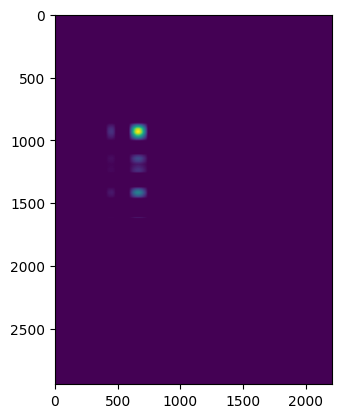

In [31]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## OpenCV可视化

In [32]:
img_bgr = cv2.imread(img_path)

In [33]:
# 检测框的颜色
bbox_color = (150,0,0)
# 检测框的线宽
bbox_thickness = 30
# 关键点半径
kpt_radius = 20
# 连接线宽
skeleton_thickness = 22

In [34]:
# 三角板关键点检测数据集-元数据（直接从config配置文件中粘贴）
dataset_info = {
    'keypoint_info': {
        0: {'name': '肾上腺', 'id': 0, 'color': [101, 205, 228], 'type': '', 'swap': ''},
        1: {'name': '耳尖', 'id': 1, 'color': [240, 128, 128], 'type': '', 'swap': ''},
        2: {'name': '胃', 'id': 2, 'color': [154, 205, 50], 'type': '', 'swap': ''},
        3: {'name': '眼', 'id': 3, 'color': [34, 139, 34], 'type': '', 'swap': ''},
        4: {'name': '口', 'id': 4, 'color': [139, 0, 0], 'type': '', 'swap': ''},
        5: {'name': '肝', 'id': 5, 'color': [255, 165, 0], 'type': '', 'swap': ''},
        6: {'name': '对屏尖', 'id': 6, 'color': [255, 0, 255], 'type': '', 'swap': ''},
        7: {'name': '心', 'id': 7, 'color': [255, 255, 0], 'type': '', 'swap': ''},
        8: {'name': '肺', 'id': 8, 'color': [29, 123,243], 'type': '', 'swap': ''},
        9: {'name': '肺2', 'id': 9, 'color': [0, 255, 255], 'type': '', 'swap': ''},
        10: {'name': '膀胱', 'id': 10, 'color': [128, 0, 128], 'type': '', 'swap': ''},
        11: {'name': '脾', 'id': 11, 'color': [74, 181, 57], 'type': '', 'swap': ''},
        12: {'name': '角窝中', 'id': 12, 'color': [165, 42, 42], 'type': '', 'swap': ''},
        13: {'name': '神门', 'id': 13, 'color': [128, 128, 0], 'type': '', 'swap': ''},
        14: {'name': '肾', 'id': 14, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        15: {'name': '耳门', 'id': 15, 'color': [34, 139, 34], 'type': '', 'swap': ''},
        16: {'name': '听宫', 'id': 16, 'color': [255, 129, 0], 'type': '', 'swap': ''},
        17: {'name': '听会', 'id': 17, 'color': [70, 130, 180], 'type': '', 'swap': ''},
        18: {'name': '肩', 'id': 18, 'color': [63, 103,165], 'type': '', 'swap': ''},
        19: {'name': '扁桃体', 'id': 19, 'color': [66, 77, 229], 'type': '', 'swap': ''},
        20: {'name': '腰骶椎', 'id': 20, 'color': [255, 105, 180], 'type': '', 'swap': ''}
    }, 
    'skeleton_info': {
        0: {'link':('眼','扁桃体'),'id': 0,'color': [100,150,200]},
        1: {'link':('耳门','听宫'),'id': 1,'color': [200,100,150]},
        2: {'link':('听宫','听会'),'id': 2,'color': [150,120,100]},
        3: {'link':('耳门','听会'),'id': 3,'color': [66,77,229]}
    }
}

In [35]:
# 关键点类别和关键点ID的映射字典
label2id = {}
for each in dataset_info['keypoint_info'].items():
    label2id[each[1]['name']] = each[0]

In [36]:
for bbox_idx, bbox in enumerate(bboxes): # 遍历每个检测框

    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox[0], bbox[1]), (bbox[2], bbox[3]), bbox_color, bbox_thickness)
    
    # 索引为 0 的框，每个关键点的坐标
    keypoints = data_samples.pred_instances.keypoints[bbox_idx,:,:].astype('int')

    # 画连线
    for skeleton_id, skeleton in dataset_info['skeleton_info'].items(): # 遍历每一种连接
        skeleton_color = skeleton['color']
        srt_kpt_id = label2id[skeleton['link'][0]] # 起始点的类别 ID
        srt_kpt_xy = keypoints[srt_kpt_id]         # 起始点的 XY 坐标
        dst_kpt_id = label2id[skeleton['link'][1]] # 终止点的类别 ID
        dst_kpt_xy = keypoints[dst_kpt_id]         # 终止点的 XY 坐标
        img_bgr = cv2.line(img_bgr, (srt_kpt_xy[0],srt_kpt_xy[1]),(dst_kpt_xy[0],dst_kpt_xy[1]),color=skeleton_color,thickness=skeleton_thickness)
    
    # 画关键点
    for kpt_idx, kpt_xy in enumerate(keypoints): # 遍历该检测框中的每一个关键点
        kpt_color = dataset_info['keypoint_info'][kpt_idx]['color']
        img_bgr = cv2.circle(img_bgr, (kpt_xy[0], kpt_xy[1]), kpt_radius, kpt_color, -1)

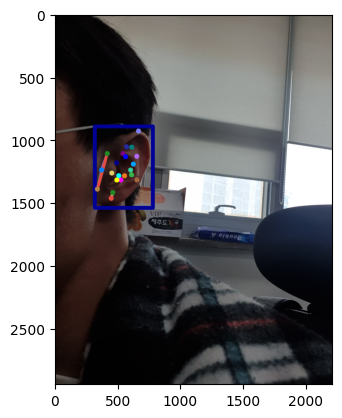

In [37]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [38]:
cv2.imwrite('../MyEar/Ear_pose.jpg', img_bgr)

True

## MMPose官方可视化工具`visualizer`

In [39]:
# 半径
pose_estimator.cfg.visualizer.radius = 30
# 线宽
pose_estimator.cfg.visualizer.line_width = 30
# pose_estimator.cfg.visualizer.font = 20
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

06/04 22:09:01 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [40]:
# pose_estimator.cfg.visualizer.font 

In [41]:
# 元数据
pose_estimator.dataset_meta

{'dataset_name': 'Ear210_Keypoint_Dataset_coco',
 'num_keypoints': 21,
 'keypoint_id2name': {0: '肾上腺',
  1: '耳尖',
  2: '胃',
  3: '眼',
  4: '口',
  5: '肝',
  6: '对屏尖',
  7: '心',
  8: '肺',
  9: '肺2',
  10: '膀胱',
  11: '脾',
  12: '角窝中',
  13: '神门',
  14: '肾',
  15: '耳门',
  16: '听宫',
  17: '听会',
  18: '肩',
  19: '扁桃体',
  20: '腰骶椎'},
 'keypoint_name2id': {'肾上腺': 0,
  '耳尖': 1,
  '胃': 2,
  '眼': 3,
  '口': 4,
  '肝': 5,
  '对屏尖': 6,
  '心': 7,
  '肺': 8,
  '肺2': 9,
  '膀胱': 10,
  '脾': 11,
  '角窝中': 12,
  '神门': 13,
  '肾': 14,
  '耳门': 15,
  '听宫': 16,
  '听会': 17,
  '肩': 18,
  '扁桃体': 19,
  '腰骶椎': 20},
 'upper_body_ids': [],
 'lower_body_ids': [],
 'flip_indices': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 'flip_pairs': [],
 'keypoint_colors': array([[101, 205, 228],
        [240, 128, 128],
        [154, 205,  50],
        [ 34, 139,  34],
        [139,   0,   0],
        [255, 165,   0],
        [255,   0, 255],
        [255, 255, 

In [42]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show=False,
            show_kpt_idx=True,
            wait_time=0,
            out_file='../MyEar/Ear_pose_visualizer.jpg',
            kpt_thr=0.3
)

In [43]:
img_output.shape

(5888, 2208, 3)

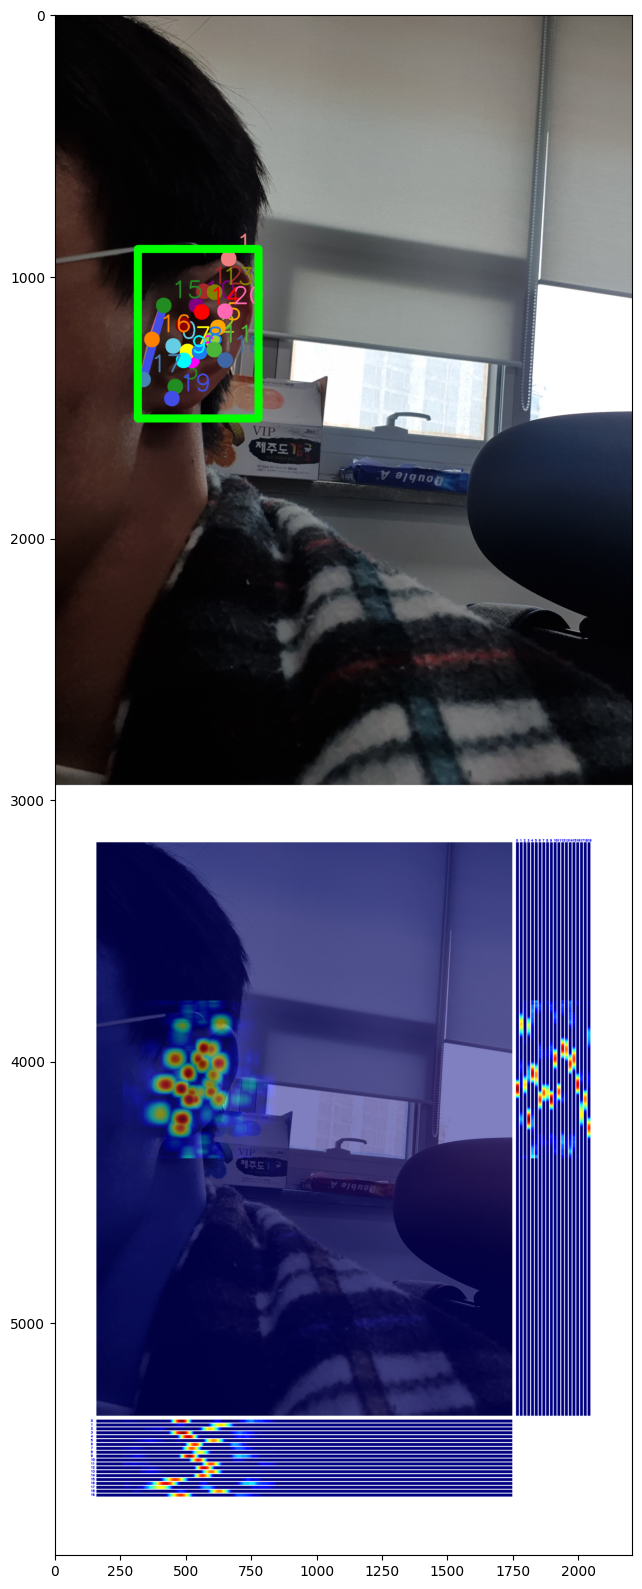

In [44]:
plt.figure(figsize=(20, 20))
plt.imshow(img_output)
plt.show()